# IBM-Coursera Capstone Project

### By Darshana Samaranayake


## Business Case

Uno Pizzeria & Grill (formerly Pizzeria Uno and Uno Chicago Grill), or more informally as Unos, is a franchised pizzeria restaurant chain under the parent company Uno Restaurant Holdings Corporation. Currently, UNO has morethan 100 locations covering 20 states in the USA.

This case study is to find a suitable location in Seattle, WA area to open a new branch of UNO Pizzeria. 

## 1.0 Business Understanding and Methodology

In general, restaurants are located in high traffic areas in order to attract more customers and provide convenient service to the people. Among most of the venues, UNO management has identified Boston, MA has been one of the high revenue location during the past few years. Therefore this study will try to find a similar location as Boston, MA. 

As the first stage of the analysis, the study will be focused on the Boston venue to identify the key attributes in that location. The study will use Foursquare, to gather 100 nearby venues with in 500 meters radius and identify the top 10 customer attraction venues. 

Importing Libraries

In [3]:
# Libraries for data analysis
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

import numpy as np


# Library for JSON files
import json
from pandas.io.json import json_normalize # helps to transform JSON into dataframe

#installing and importing geopy for location
#pip install geopy 
from geopy.geocoders import Nominatim

#Library to handle requests
import requests

# Importing plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Import K-means
from sklearn.cluster import KMeans

import folium # rendering maps
print('Libraries imported.')



Libraries imported.


## 1.1 Analyzing existing UNO Store surrounding

In [4]:
store_address = '645 Beacon St, Boston, MA 02215'

geolocator = Nominatim(user_agent="ma_explorer")
location = geolocator.geocode(store_address)
latitude = location.latitude
longitude = location.longitude
print('Geo Cordinates of UNO Pizza - Boston are {}, {}.'.format(latitude, longitude))



Geo Cordinates of UNO Pizza - Boston are 42.34836865, -71.09772767070396.


Exploring the area with Foursquare

In [5]:
CLIENT_ID = 'V21UD1YVJ4U1MLPYB3HUEFRJJ1PA011WOA3VNLBNF0ZBM01L' # your Foursquare ID
CLIENT_SECRET = '0UF2O5ZQBERLPLQFESLXCIY3PP4A3HACWNUT5X2K5H3SKAWN' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: V21UD1YVJ4U1MLPYB3HUEFRJJ1PA011WOA3VNLBNF0ZBM01L
CLIENT_SECRET:0UF2O5ZQBERLPLQFESLXCIY3PP4A3HACWNUT5X2K5H3SKAWN


In [6]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=V21UD1YVJ4U1MLPYB3HUEFRJJ1PA011WOA3VNLBNF0ZBM01L&client_secret=0UF2O5ZQBERLPLQFESLXCIY3PP4A3HACWNUT5X2K5H3SKAWN&v=20180604&ll=42.34836865,-71.09772767070396&radius=500&limit=100'

In [7]:
req = requests.get(url).json()

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
latitudes = np.array([latitude])
longitudes = np.array([longitude])
neighborhood_name = ['UNO Pizza']

around_uno = getNearbyVenues(names=neighborhood_name,
                                   latitudes=latitudes,
                                   longitudes=longitudes
                                  )

UNO Pizza


In [10]:
print(around_uno.shape)
around_uno.head()

(100, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,UNO Pizza,42.348369,-71.097728,Island Creek Oyster Bar,42.348838,-71.095280,Seafood Restaurant
1,UNO Pizza,42.348369,-71.097728,Fenway Park,42.346282,-71.097535,Baseball Stadium
2,UNO Pizza,42.348369,-71.097728,House of Blues,42.347244,-71.095802,Music Venue
3,UNO Pizza,42.348369,-71.097728,Eastern Standard,42.348687,-71.096127,American Restaurant
4,UNO Pizza,42.348369,-71.097728,Dell EMC Club,42.346016,-71.097996,Lounge


In [11]:
around_uno.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
UNO Pizza,100,100,100,100,100,100


In [12]:
print('There are {} uniques categories.'.format(len(around_uno['Venue Category'].unique())))

There are 59 uniques categories.


In [13]:
# one hot encoding
uno_onehot = pd.get_dummies(around_uno[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uno_onehot['Neighborhood'] = around_uno['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [uno_onehot.columns[-1]] + list(uno_onehot.columns[:-1])
uno_onehot = uno_onehot[fixed_columns]

uno_onehot.head()

,Vietnamese Restaurant,American Restaurant,Art Gallery,Athletics & Sports,Bank,Bar,Baseball Field,Baseball Stadium,Bookstore,Bowling Alley,Brewery,Burger Joint,Burrito Place,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Cycle Studio,Department Store,Doctor's Office,Donut Shop,Fast Food Restaurant,Food Truck,Garden,Gay Bar,Greek Restaurant,Gym,Gym / Fitness Center,Hot Dog Joint,Hotel,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Liquor Store,Lounge,Mexican Restaurant,Music Store,Music Venue,Neighborhood,Pedestrian Plaza,Pharmacy,Pizza Place,Pub,Record Shop,Restaurant,Roof Deck,Salad Place,Seafood Restaurant,Smoke Shop,Souvenir Shop,Sports Bar,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Tour Provider,Trail,Vegetarian / Vegan Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UNO Pizza,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UNO Pizza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,UNO Pizza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UNO Pizza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,UNO Pizza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
uno_onehot.shape

(100, 59)

Grouping the venues and find the mean values for further processing

In [15]:
uno_grouped = uno_onehot.groupby('Neighborhood').mean().reset_index()
uno_grouped

,Neighborhood,Vietnamese Restaurant,American Restaurant,Art Gallery,Athletics & Sports,Bank,Bar,Baseball Field,Baseball Stadium,Bookstore,Bowling Alley,Brewery,Burger Joint,Burrito Place,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Cycle Studio,Department Store,Doctor's Office,Donut Shop,Fast Food Restaurant,Food Truck,Garden,Gay Bar,Greek Restaurant,Gym,Gym / Fitness Center,Hot Dog Joint,Hotel,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Liquor Store,Lounge,Mexican Restaurant,Music Store,Music Venue,Pedestrian Plaza,Pharmacy,Pizza Place,Pub,Record Shop,Restaurant,Roof Deck,Salad Place,Seafood Restaurant,Smoke Shop,Souvenir Shop,Sports Bar,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Tour Provider,Trail,Vegetarian / Vegan Restaurant
0,UNO Pizza,0.01,0.06,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.02,0.03,0.01,0.03,0.01,0.05,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.03,0.01,0.01,0.01,0.03,0.01,0.01,0.04,0.02,0.01,0.01,0.01,0.01,0.05,0.02,0.01,0.02,0.01,0.01,0.02,0.01,0.01,0.07,0.02,0.01,0.01,0.01,0.01,0.01


In [16]:
uno_grouped.shape

(1, 59)

Finding the top 10 venues around the UNO Pizza at Boston.

In [17]:
num_top_venues = 10

for hood in uno_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = uno_grouped[uno_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----UNO Pizza----
                 venue  freq
0           Sports Bar  0.07
1  American Restaurant  0.06
2          Pizza Place  0.05
3          Coffee Shop  0.05
4               Lounge  0.04
5                Hotel  0.03
6                 Café  0.03
7         Burger Joint  0.03
8  Japanese Restaurant  0.03
9     Sushi Restaurant  0.02




It appears the UNO at Boston is mainly surrounded by bars and resturants

In [19]:
map_uno= folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
lat, lng, label = latitude,longitude, store_address
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_uno)  

# add markers to map
for lat, lng, venue in zip(around_uno['Venue Latitude'], around_uno['Venue Longitude'], around_uno['Venue Category']):
    label = '{}, {}'.format('Mayfair', venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_uno)  
    
map_uno

## 1.2 Summary

After analysing the existing Uno Pizzaria at Boston, below venues have been identified as top 10 venues around the Pizzaria.

                 
1           Sports Bar     

2  American Restaurant     

3          Pizza Place     

4          Coffee Shop    

5               Lounge     

6                Hotel    

7                 Café    

8        Burger Joint     

9  Japanese Restaurant    

10     Sushi Restaurant     


## 2. Analyzing areas in Seattle for a new UNO Pizzeria

In order to analyze the Seattle are, Seattle's Neighbourhoods and districts data were scrapped from wikipidia. This data have been wrangled and cleaned. Geospacial data --latitude and longitude for each Neighbourhoud, were added for each Neighbourhood using Foursquare. The resulting Pandas DataFrame was also converted into a .csv file format suitable for analysis. 

In [21]:
cd /Users/darshana/Documents/GitHub/CourseraCapstone

/Users/darshana/Documents/GitHub/CourseraCapstone


In [22]:
df_seattle = pd.read_csv('Seattle_neighbourhoods_Districts.csv')
df_seattle.head()

,District,Neighbourhood
0,Ballard,Adams
1,Ballard,Loyal Heights
2,Ballard,Sunset Hill
3,Ballard,West Woodland
4,Ballard,Whittier Heights


Adding Lattitude and Longitude into the seattle dataframe

In [23]:
# define the dataframe columns
column_names = ['District', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
seattle = pd.DataFrame(columns=column_names)
seattle

,District,Neighbourhood,Latitude,Longitude


In [24]:
for index, row in df_seattle.iterrows():
      
    address = row['Neighbourhood'] + ', Seattle, WA'
    
    #loop until you get the coordinates
    #while (latitude is None or longitude is None):
    try:   
        geolocator = Nominatim(user_agent="se_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
       # print('The geograpical coordinate of ' + address + ' are {}, {}.'.format(latitude, longitude))

        seattle = seattle.append({'District': row['District'],
                                          'Neighbourhood': row['Neighbourhood'],
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)
    except AttributeError:
        pass

In [25]:
seattle.head()

,District,Neighbourhood,Latitude,Longitude
0,Ballard,Adams,47.565271,-122.279546
1,Ballard,Loyal Heights,47.688709,-122.392907
2,Ballard,Sunset Hill,47.675217,-122.398448
3,Ballard,West Woodland,47.675973,-122.347499
4,Ballard,Whittier Heights,47.683297,-122.371449


### 2.1 Finding the Lttitude and Longitude of nearby venues in Seattle, WA

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
seattle_venues = getNearbyVenues(names=seattle['Neighbourhood'],
                                   latitudes=seattle['Latitude'],
                                   longitudes=seattle['Longitude']
                                  )

Adams
Loyal Heights
Sunset Hill
West Woodland
Whittier Heights
Holly Park
North Beacon Hill
South Beacon Hill
Broadway
Madison Park
Montlake
Portage Bay
Stevens
Eastlake
South Lake Union
Westlake
Atlantic
Harrison/Denny-Blaine
Leschi
Madrona
Mann
Minor
Highland Park
High Point
North Delridge
Riverview
Roxhill
South Delridge
Belltown
Central Business District
First Hill
International District
Pike-Market
Pioneer Square
Yesler Terrace
Interbay
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Briarcliff
Lawton Park
Southeast Magnolia
Haller Lake
Maple Leaf
North College Park
Pinehurst
Bitter Lake
Broadview
Bryant
Crown Hill
Fremont
Georgetown
Green Lake
Greenwood
Harbor Island
Laurelhurst
Phinney Ridge
Ravenna
Roosevelt
Sand Point
South Park
View Ridge
Wallingford
Wedgwood
Windermere
East Queen Anne
Lower Queen Anne
North Queen Anne
West Queen Anne
Brighton
Columbia City
Dunlap
Mount Baker
Rainier Beach
Rainier View
Seward Park
University District
Alki
Arbor Heights
Fai

In [28]:
seattle_venues.shape

(2339, 7)

In [29]:
seattle_venues.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adams,47.565271,-122.279546,Genesee Dog Park,47.563495,-122.276687,Dog Run
1,Adams,47.565271,-122.279546,Genesee Park - Soccer Fields,47.562986,-122.278359,Soccer Field
2,Adams,47.565271,-122.279546,Genesee Park & Playground,47.564485,-122.279274,Park
3,Loyal Heights,47.688709,-122.392907,Cafe Munir,47.686908,-122.387996,Middle Eastern Restaurant
4,Loyal Heights,47.688709,-122.392907,Larsen's Bakery,47.686804,-122.387524,Bakery


In [30]:
seattle_venues.groupby('Neighbourhood').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Adams,3,3,3,3,3,3
Alki,38,38,38,38,38,38
Arbor Heights,1,1,1,1,1,1
Atlantic,10,10,10,10,10,10
Belltown,69,69,69,69,69,69
Bitter Lake,25,25,25,25,25,25
Briarcliff,4,4,4,4,4,4
Brighton,4,4,4,4,4,4
Broadview,9,9,9,9,9,9


Finding the number of unique venues in each neighborhood

In [31]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 287 uniques categories.


### 2.2 Analyzing the each neighborhood

Here, we are going to use one hot encoding to analize the neighborhoods

In [32]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighbourhood'] = seattle_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head()

,Neighbourhood,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Floating Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,

In [33]:
seattle_grouped = seattle_onehot.groupby('Neighbourhood').mean().reset_index()
seattle_grouped.shape

(86, 288)

### 2.3 Finding the top 10 venues in each neighborhood

In order to match with Boston area, we need to find the top venues in each neighborhood. Here, the dataset will be sorted based on the frequency of each venue.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sorted_venues = pd.DataFrame(columns=columns)
sorted_venues['Neighbourhood'] = seattle_grouped['Neighbourhood']

for ind in np.arange(seattle_grouped.shape[0]):
    sorted_venues.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

sorted_venues.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Park,Dog Run,Soccer Field,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
1,Alki,Ice Cream Shop,Coffee Shop,Mexican Restaurant,Italian Restaurant,Restaurant,Park,Thai Restaurant,Scenic Lookout,Baseball Field,Baseball Stadium
2,Arbor Heights,Park,Hotel,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Zoo Exhibit
3,Atlantic,Sporting Goods Shop,Thrift / Vintage Store,Cheese Shop,Food Truck,Marijuana Dispensary,Rental Car Location,Intersection,Electronics Store,Light Rail Station,Grocery Store
4,Belltown,Hotel,Bakery,Sushi Restaurant,Coffee Shop,Gym,Bar,Cocktail Bar,Cruise,Deli / Bodega,New American Restaurant


## 3. Clustering neighborhoods

Now we have found the top 10 venues of each neighborhood. The next step is groping the neighborhoods using K-Mean clustering. 

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(seattle_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [37]:
# set number of clusters
kclusters = 4

seattle_grouped_clustering = seattle_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 1, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

In [38]:
# add clustering labels
sorted_venues.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = seattle

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(sorted_venues.set_index('Neighbourhood'), on='Neighbourhood')

# check the last columns!
seattle_merged.head()

,District,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballard,Adams,47.565271,-122.279546,1.0,Park,Dog Run,Soccer Field,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
1,Ballard,Loyal Heights,47.688709,-122.392907,2.0,Pizza Place,General College & University,Fish Market,Music Store,Convenience Store,Bakery,Middle Eastern Restaurant,Mexican Restaurant,Café,Fabric Shop
2,Ballard,Sunset Hill,47.675217,-122.398448,2.0,Bakery,Ice Cream Shop,Weight Loss Center,Cocktail Bar,Italian Restaurant,Fair,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
3,Ballard,West Woodland,47.675973,-122.347499,0.0,Zoo Exhibit,Park,Asian Restaurant,Trail,Caribbean Restaurant,Bowling Green,Dumpling Restaurant,Floating Market,Fish Market,Fish & Chips Shop
4,Ballard,Whittier Heights,47.683297,-122.371449,2.0,Bar,Breakfast Spot,Bus Stop,Furniture / Home Store,Bakery,Karaoke Bar,Park,Cocktail Bar,Trail,Rental Car Location


In [39]:

seattle_merged = seattle_merged[seattle_merged['Cluster Labels'].notna()]

In [40]:

cluster_labels = seattle_merged['Cluster Labels'].astype(int)

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
cluster_labels = seattle_merged['Cluster Labels'].astype(int)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighbourhood'], cluster_labels):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4. Evaluating the Clusters

Now we have four clusters, which has grouped similar neighborhoods based on the venues. Now we have to evaluate those clusters and find a matching cluster with Boston

##### Below are the top 10 venues in Boston

In [42]:
#-----UNO Pizza----
#                 venue  freq
#0           Sports Bar  0.07
#1  American Restaurant  0.05
#2          Pizza Place  0.05
#3          Coffee Shop  0.05
#4                Hotel  0.04
#5               Lounge  0.04
#6                 Café  0.03
#7         Burger Joint  0.03
#8  Japanese Restaurant  0.03
#9     Sushi Restaurant  0.02


In [43]:
Cluster_1 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]
Cluster_1

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,West Woodland,Zoo Exhibit,Park,Asian Restaurant,Trail,Caribbean Restaurant,Bowling Green,Dumpling Restaurant,Floating Market,Fish Market,Fish & Chips Shop
22,Highland Park,Baseball Field,Home Service,Construction & Landscaping,Playground,Business Service,Fabric Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
23,High Point,Park,Field,Playground,Spa,Bus Station,Zoo Exhibit,Eye Doctor,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
24,North Delridge,Gas Station,Park,Convenience Store,Pizza Place,Trail,Vietnamese Restaurant,Pet Service,Event Space,Dumpling Restaurant,Eastern European Restaurant
25,Riverview,Park,Trail,Baseball Field,Bus Station,Eye Doctor,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop
27,South Delridge,Gas Station,Park,Convenience Store,Pizza Place,Trail,Vietnamese Restaurant,Pet Service,Event Space,Dumpling Restaurant,Eastern European Restaurant
38,Meadowbrook,Playground,Pool,Pizza Place,Art Gallery,Zoo Exhibit,Fair,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
39,Olympic Hills,Pool Hall,Middle Eastern Restaurant,Farmers Market,Zoo Exhibit,Fabric Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor
40,Victory Heights,Marijuana Dispensary,Playground,Garden,Zoo Exhibit,Fabric Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor
41,Briarcliff,Park,Trail,Bus Stop,Athletics & Sports,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space


In [44]:
Cluster_2 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]
Cluster_2

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Park,Dog Run,Soccer Field,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
5,Holly Park,Park,Brewery,Playground,Fair,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
18,Leschi,Park,Playground,Pizza Place,Grocery Store,Pet Store,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
37,Matthews Beach,Park,Trail,Playground,Eye Doctor,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
42,Lawton Park,Park,Coffee Shop,Breakfast Spot,Playground,Gas Station,Chiropractor,Restaurant,Grocery Store,Event Space,Eastern European Restaurant
50,Bryant,Wine Shop,Organic Grocery,Park,Zoo Exhibit,Eye Doctor,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
54,Green Lake,Park,Theater,Trail,Tennis Court,Beach,Lake,Zoo Exhibit,Event Space,Eastern European Restaurant,Electronics Store
62,South Park,Park,Brewery,Bar,Fish Market,Floating Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
63,View Ridge,Park,Hotel,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Zoo Exhibit
66,Windermere,Park,Greek Restaurant,Pizza Place,Eye Doctor,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space


In [45]:
Cluster_3 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[1] + list(range(0, seattle_merged.shape[1]))]]
Cluster_3

,Neighbourhood,District,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Loyal Heights,Ballard,Loyal Heights,47.688709,-122.392907,2.0,Pizza Place,General College & University,Fish Market,Music Store,Convenience Store,Bakery,Middle Eastern Restaurant,Mexican Restaurant,Café,Fabric Shop
2,Sunset Hill,Ballard,Sunset Hill,47.675217,-122.398448,2.0,Bakery,Ice Cream Shop,Weight Loss Center,Cocktail Bar,Italian Restaurant,Fair,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
4,Whittier Heights,Ballard,Whittier Heights,47.683297,-122.371449,2.0,Bar,Breakfast Spot,Bus Stop,Furniture / Home Store,Bakery,Karaoke Bar,Park,Cocktail Bar,Trail,Rental Car Location
6,North Beacon Hill,Beacon Hill,North Beacon Hill,47.577586,-122.309960,2.0,Mexican Restaurant,Pub,Coffee Shop,Café,Trail,Pizza Place,Dance Studio,Peking Duck Restaurant,Park,Brewery
7,South Beacon Hill,Beacon Hill,South Beacon Hill,47.577586,-122.309960,2.0,Mexican Restaurant,Pub,Coffee Shop,Café,Trail,Pizza Place,Dance Studio,Peking Duck Restaurant,Park,Brewery
8,Broadway,Capitol Hill,Broadway,47.613972,-122.320827,2.0,Ramen Restaurant,Coffee Shop,Mexican Restaurant,Ice Cream Shop,Café,Burger Joint,Cocktail Bar,Donut Shop,French Restaurant,Gym
9,Madison Park,Capitol Hill,Madison Park,47.635930,-122.280196,2.0,Bar,Park,Bank,Mexican Restaurant,Spa,Food & Drink Shop,Pizza Place,Café,Dry Cleaner,Beach
10,Montlake,Capitol Hill,Montlake,47.641408,-122.303044,2.0,Bus Stop,Coffee Shop,Park,Bus Line,Grocery Store,Bike Shop,Italian Restaurant,American Restaurant,Library,Farmers Market
11,Portage Bay,Capitol Hill,Portage Bay,47.647484,-122.319286,2.0,Café,Bus Stop,Eastern European Restaurant,Playground,American Restaurant,Pizza Place,Deli / Bodega,Mexican Restaurant,Art Gallery,Boat Rental
12,Stevens,Capitol Hill,Stevens,47.654349,-122.315996,2.0,Sandwich Place,Park,Harbor / Marina,Korean Restaurant,Coffee Shop,Vietnamese Restaurant,New American Restaurant,Chinese Restaurant,Thai Restaurant,Burger Joint


In [46]:
Cluster_4 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 3, seattle_merged.columns[[1] + list(range(0, seattle_merged.shape[1]))]]
Cluster_4

,Neighbourhood,District,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Cedar Park,Lake City,Cedar Park,47.725653,-122.28596,3.0,Vietnamese Restaurant,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Zoo Exhibit


### 4.1 Selecting the matching cluster. 

After evaluvating the four clusters, it is clear that Cluster 3 has the best combination. Therefore, Cluster 3 will be further analyzed to find the perfect neighborhood.

In [58]:
print('The shape of cluster 3 is: ', Cluster_3.shape)
print('The size of cluster 3 is: ', Cluster_3.size)
Cluster_3

The shape of cluster 3 is:  (55, 16)
The size of cluster 3 is:  880


,Neighbourhood,District,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Loyal Heights,Ballard,Loyal Heights,47.688709,-122.392907,2.0,Pizza Place,General College & University,Fish Market,Music Store,Convenience Store,Bakery,Middle Eastern Restaurant,Mexican Restaurant,Café,Fabric Shop
2,Sunset Hill,Ballard,Sunset Hill,47.675217,-122.398448,2.0,Bakery,Ice Cream Shop,Weight Loss Center,Cocktail Bar,Italian Restaurant,Fair,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
4,Whittier Heights,Ballard,Whittier Heights,47.683297,-122.371449,2.0,Bar,Breakfast Spot,Bus Stop,Furniture / Home Store,Bakery,Karaoke Bar,Park,Cocktail Bar,Trail,Rental Car Location
6,North Beacon Hill,Beacon Hill,North Beacon Hill,47.577586,-122.309960,2.0,Mexican Restaurant,Pub,Coffee Shop,Café,Trail,Pizza Place,Dance Studio,Peking Duck Restaurant,Park,Brewery
7,South Beacon Hill,Beacon Hill,South Beacon Hill,47.577586,-122.309960,2.0,Mexican Restaurant,Pub,Coffee Shop,Café,Trail,Pizza Place,Dance Studio,Peking Duck Restaurant,Park,Brewery
8,Broadway,Capitol Hill,Broadway,47.613972,-122.320827,2.0,Ramen Restaurant,Coffee Shop,Mexican Restaurant,Ice Cream Shop,Café,Burger Joint,Cocktail Bar,Donut Shop,French Restaurant,Gym
9,Madison Park,Capitol Hill,Madison Park,47.635930,-122.280196,2.0,Bar,Park,Bank,Mexican Restaurant,Spa,Food & Drink Shop,Pizza Place,Café,Dry Cleaner,Beach
10,Montlake,Capitol Hill,Montlake,47.641408,-122.303044,2.0,Bus Stop,Coffee Shop,Park,Bus Line,Grocery Store,Bike Shop,Italian Restaurant,American Restaurant,Library,Farmers Market
11,Portage Bay,Capitol Hill,Portage Bay,47.647484,-122.319286,2.0,Café,Bus Stop,Eastern European Restaurant,Playground,American Restaurant,Pizza Place,Deli / Bodega,Mexican Restaurant,Art Gallery,Boat Rental
12,Stevens,Capitol Hill,Stevens,47.654349,-122.315996,2.0,Sandwich Place,Park,Harbor / Marina,Korean Restaurant,Coffee Shop,Vietnamese Restaurant,New American Restaurant,Chinese Restaurant,Thai Restaurant,Burger Joint


It is important to pick an urban neighborhood for the pizzaria, Therefore we should filter only the central and downtown area, as it may help to find more foot traffic. 

In [48]:
Cluster_3_Central = Cluster_3[Cluster_3.District == 'Central Area']
Cluster_3_downtown = Cluster_3[Cluster_3.District == 'Downtown'] 

Cluster_3_filtered = Cluster_3_Central.append(Cluster_3_downtown)

Cluster_3_filtered = Cluster_3_filtered[['Neighbourhood', 'District', 'Latitude', 'Longitude']].copy()
Cluster_3_filtered = Cluster_3_filtered.loc[:,~Cluster_3_filtered.columns.duplicated()]
Cluster_3_filtered.shape

(12, 4)

In [49]:
downtown_venues = getNearbyVenues(names=Cluster_3_filtered['Neighbourhood'],
                                   latitudes=Cluster_3_filtered['Latitude'],
                                   longitudes=Cluster_3_filtered['Longitude']
                                  )

Atlantic
Harrison/Denny-Blaine
Madrona
Mann
Minor
Belltown
Central Business District
First Hill
International District
Pike-Market
Pioneer Square
Yesler Terrace


In [50]:
downtown_venues.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Atlantic,47.590493,-122.324313,RE-PC,47.588489,-122.326324,Electronics Store
1,Atlantic,47.590493,-122.324313,Big John's PFI,47.594397,-122.327075,Cheese Shop
2,Atlantic,47.590493,-122.324313,Dockside Cannabis Sodo,47.587318,-122.328653,Marijuana Dispensary
3,Atlantic,47.590493,-122.324313,Outdoor Emporium,47.587867,-122.329409,Sporting Goods Shop
4,Atlantic,47.590493,-122.324313,El Camión,47.594576,-122.325144,Food Truck


In [51]:
downtown_venues.groupby('Neighbourhood').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Atlantic,10,10,10,10,10,10
Belltown,69,69,69,69,69,69
Central Business District,74,74,74,74,74,74
First Hill,43,43,43,43,43,43
Harrison/Denny-Blaine,20,20,20,20,20,20
International District,80,80,80,80,80,80
Madrona,29,29,29,29,29,29
Mann,98,98,98,98,98,98
Minor,57,57,57,57,57,57


### 4.2 Finding the most suitable neighborhood from Cluster 3 

Here we again use one hot encoding to find and sort the venues around each neighborhood.

In [52]:

# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_onehot['Neighbourhood'] = downtown_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.head()

,Neighbourhood,ATM,Accessories Store,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Store,Bike Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Stop,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cruise,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Grocery Store,Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Herbs & Spices Store,Historic Site,History Museum,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Light Rail Station,Lounge,Marijuana Dispensary,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Movie Theater,Museum,New American Restaurant,Nightclub,Noodle House,Other Nightlife,Outdoor Supply Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool Hall,Pub,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shopping Mall,Snack Place,Social Club,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Atlantic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Atlantic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Atlantic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Atlantic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Atlantic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [53]:
downtown_onehot.shape

(701, 170)

In [54]:
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

We will be analyzing the data using categorical plot. That makes easier to identify the suitable neighborhood with visualization. We are going to find the top 10 venues we found in Boston area and check the frequency of each of those venues in each selected neighborhoods in Seattle.

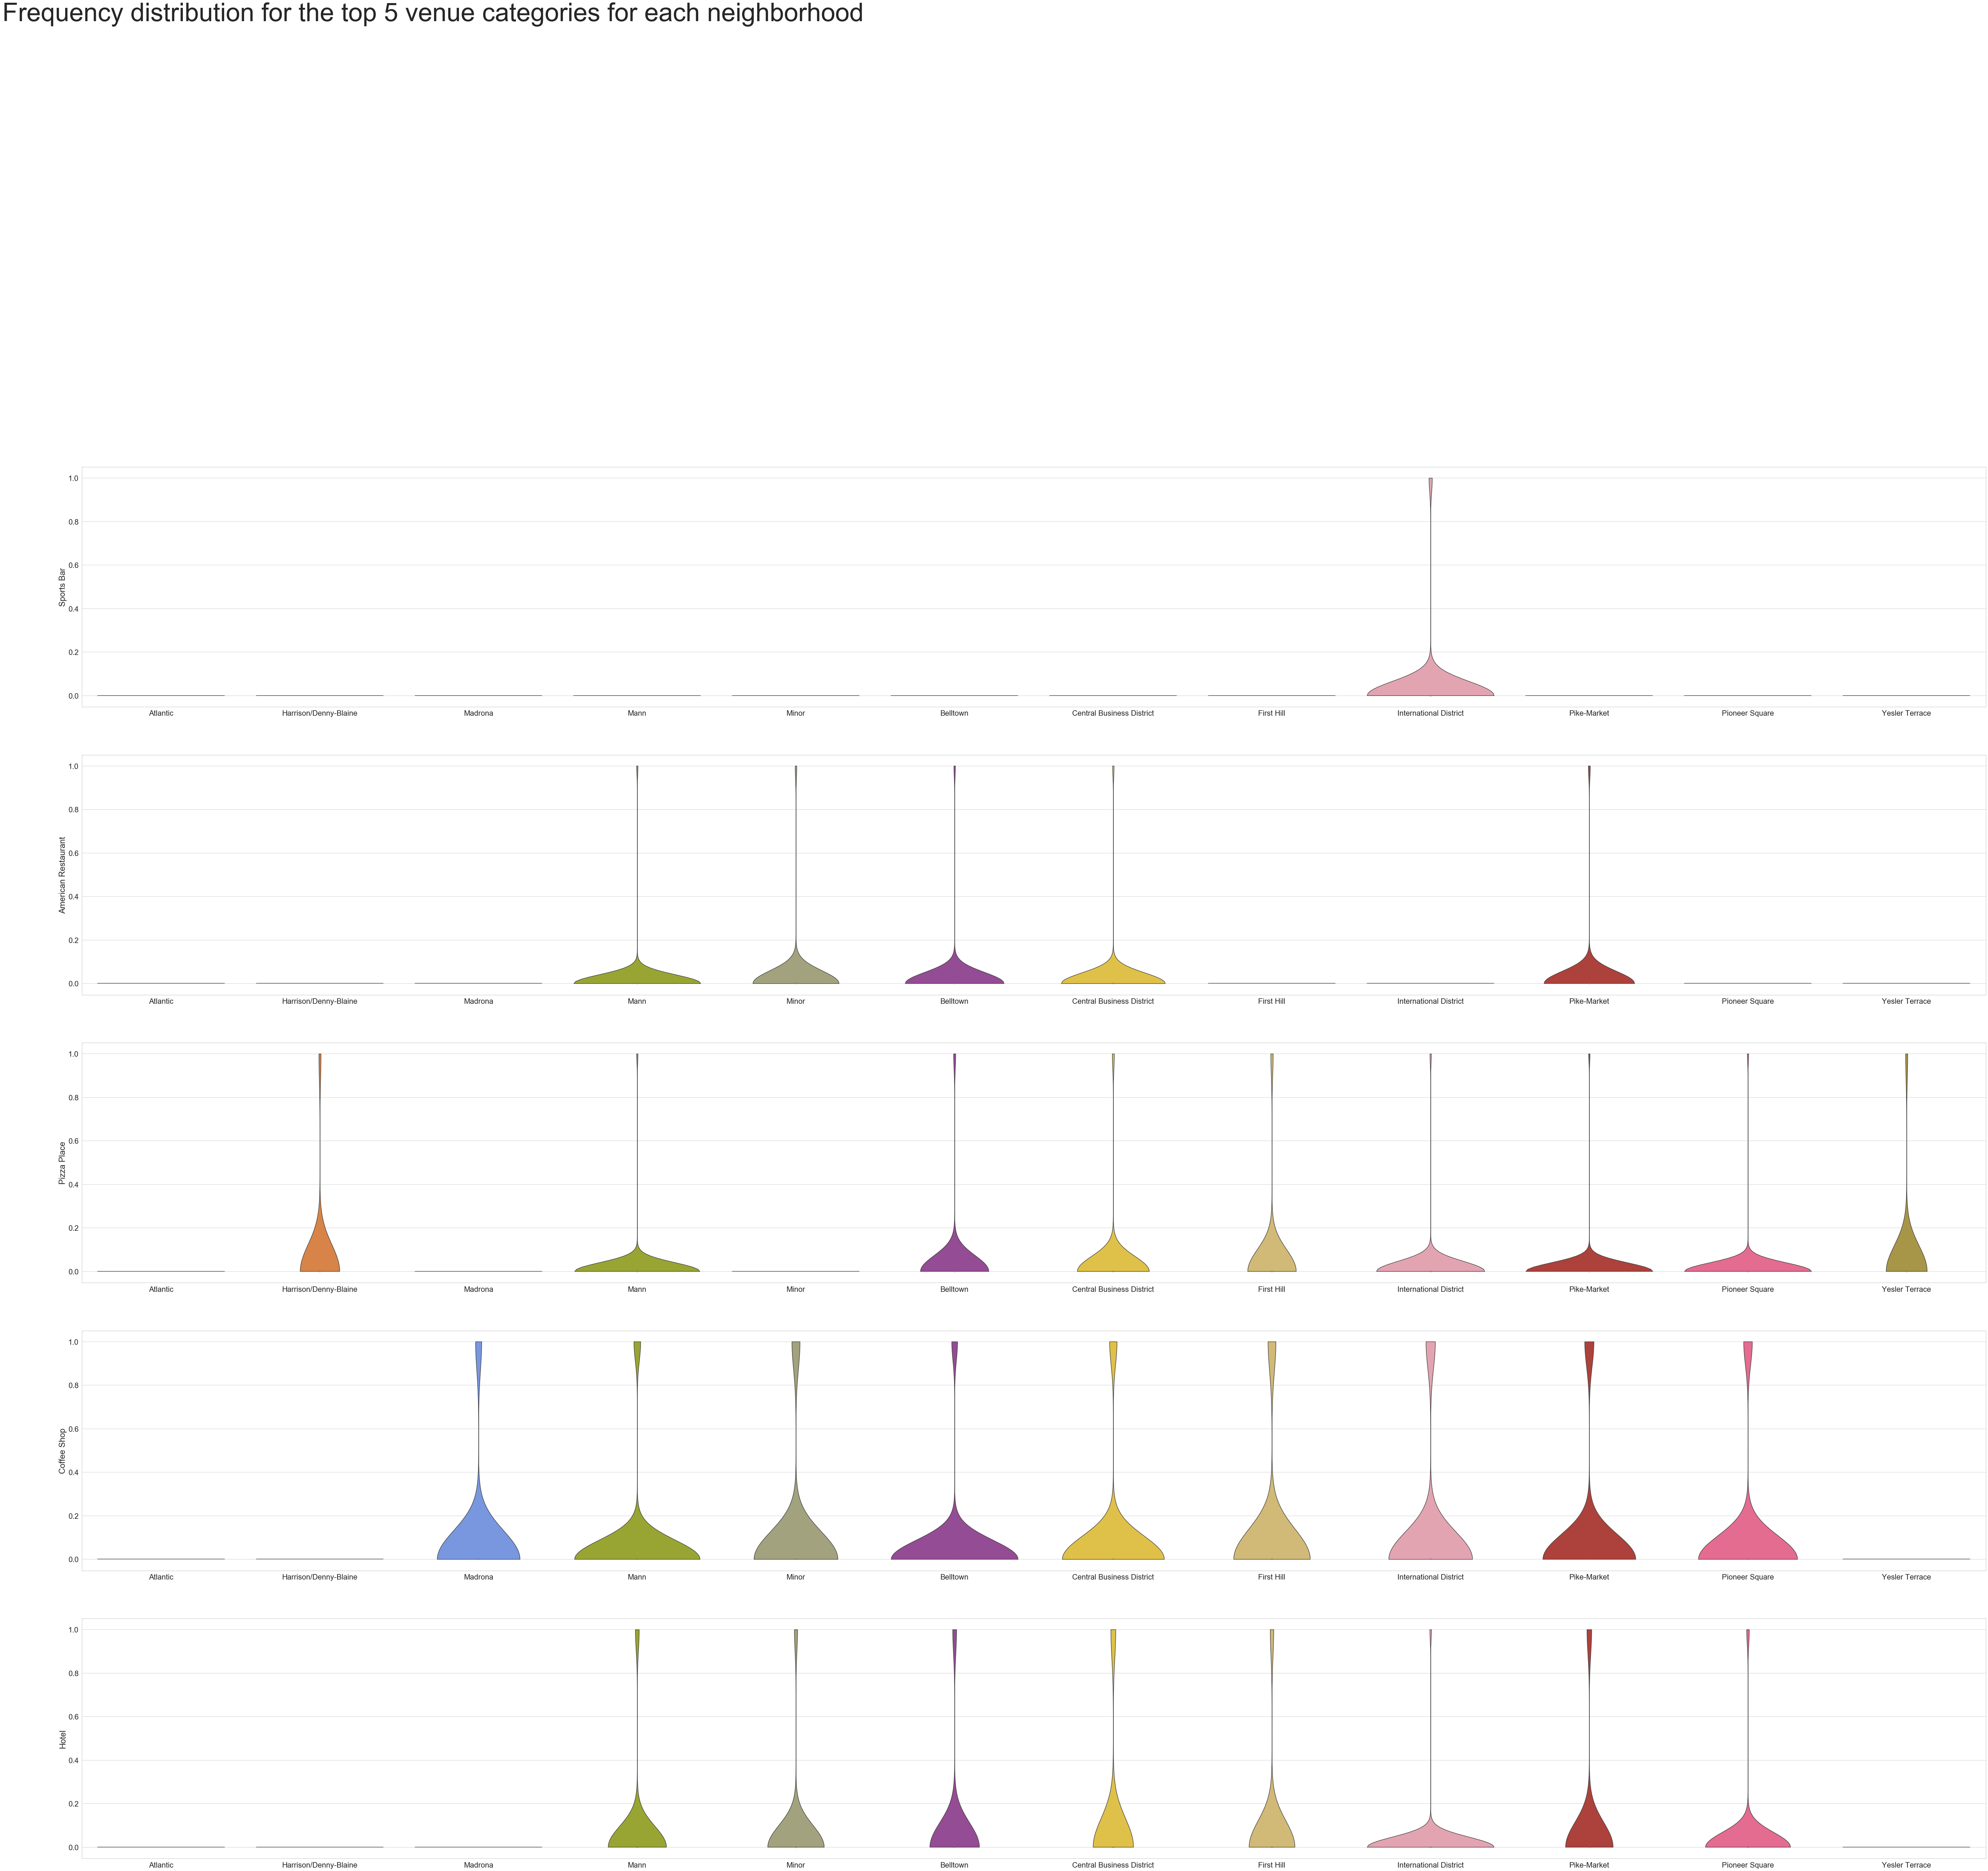

In [56]:
# Categorical plot
# Explore a plot of this data (a violin plot is used which is a density estimation of the underlying distribution).
# The top 3 venue types as specified by the client for each neighborhood are used for the plotting.

import seaborn as sns

fig = plt.figure(figsize=(100,75))
sns.set(font_scale=2)
sns.set_style('whitegrid')
ax = plt.subplot(5,1,1)

##plt.subplot(5,1,1)

sns.violinplot(x="Neighbourhood", y="Sports Bar", data=downtown_onehot, cut=0,palette=pkmn_type_colors);
plt.xlabel("")

plt.subplot(5,1,2)
sns.violinplot(x="Neighbourhood", y="American Restaurant", data=downtown_onehot, cut=0,palette=pkmn_type_colors);
plt.xlabel("")

plt.subplot(5,1,3)
sns.violinplot(x="Neighbourhood", y="Pizza Place", data=downtown_onehot, cut=0,palette=pkmn_type_colors);
plt.xlabel("")

plt.subplot(5,1,4)
sns.violinplot(x="Neighbourhood", y="Coffee Shop", data=downtown_onehot, cut=0,palette=pkmn_type_colors);
plt.xlabel("")

plt.subplot(5,1,5)
sns.violinplot(x="Neighbourhood", y="Hotel", data=downtown_onehot, cut=0,palette=pkmn_type_colors);
plt.xlabel("")


ax.text(-1.0, 3.1, 'Frequency distribution for the top 5 venue categories for each neighborhood', fontsize=75)
plt.savefig ("Distribution_Frequency_Venues_10_categories.png", dpi=240)
plt.show()

#venue  freq
#0           Sports Bar  0.07
#1  American Restaurant  0.05
#2          Pizza Place  0.05
#3          Coffee Shop  0.05
#4                Hotel  0.04
#5               Lounge  0.04
#6                 Café  0.03
#7         Burger Joint  0.03


### 4.4 Observations

After looking at the above plot, most of the neighborhoods have considerable amount of venues which are matching to Boston neighborhood. However, we will select the "International District" among the other neighborhoods.It contains Sports bars which is the top venue in Boston, and it has four out of five of other venues as well. 

In [57]:
# create map of seattle using the above obtained geo cordinates. 
map_Cluster_2New = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(Cluster_3_filtered['Latitude'], Cluster_3_filtered['Longitude'], Cluster_3_filtered['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_Cluster_2New) 

Lat_p = float(Cluster_3_filtered[Cluster_3_filtered.Neighbourhood == 'International District']['Latitude'])
Long_p = float(Cluster_3_filtered[Cluster_3_filtered.Neighbourhood == 'International District']['Longitude'])

#map_Cluster_2New = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
lat, lng, label = Lat_p ,Long_p, 'International District'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Cluster_2New)  

# create map of New York using latitude and longitude values
 
    
map_Cluster_2New

## 5. Conclusion

After completing the study, "International District" has been selected as the most suitable neighborhood to open the new UNO pizzaria in Seattle, WA. The step by step process shows how the selection was made with the help of a few python libraries, visualization, K-means clustering with Foursqure location data.